# Euclidean Heat Kernel - Diffusion & Denoising

In this notebook, we will show how we can
- use the exact score function for the Euclidean heat kernel to reverse the forward diffusion process
- train a neural network to approximate this score function and replicate the same denoising procedure
  
The idea is that we can have a direct comparison between our ML results and the analytical results, since we know the score function for the heat kernel exactly.

*Note: In more practical applications when we start with non-trivial 'training data' (i.e., give the heat equation initial conditions), we do not know the true score function for all time.*

## Setup

In [1]:
# General imports
import numpy as np
import torch
import math

import tqdm.auto as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import sun_diffusion

from sun_diffusion import VarianceExpandingDiffusion
from sun_diffusion.heat import eucl_score_hk
from sun_diffusion.devices import set_device, get_device, summary
from sun_diffusion.utils import grab, wrap

In [3]:
set_device('cuda', 0)
print(summary())

Using device: cuda:0 (NVIDIA GH200 120GB) with dtype: torch.float32


## Background: Euclidean Diffusion

Diffusion is a stochastic process described by $$dx = g(t) dW$$ that corresponds to the heat equation: $$\partial_t u(x, t) = \frac{g(t)^2}{2} \Delta u(x, t).$$ 

The diffusion coefficient $g$ gives rise to a postive, time-dependent scalar quantity $\sigma^2$ we call the *diffusivity*. For *variance-expanding* diffusion, the diffusion coefficient is $g(t) = \kappa^t$, which yields a diffusivity of

$$\sigma(t) = \sqrt{\int_0^t g(s)^2 ds} = \sqrt{\frac{\kappa^{2t} - 1}{2\log\kappa}}$$

for constant $\kappa > 0$. 

In [4]:
def variance_expanding_std(kappa, t):
    return ((kappa ** (2*t) - 1) / (2 * math.log(kappa)))**0.5

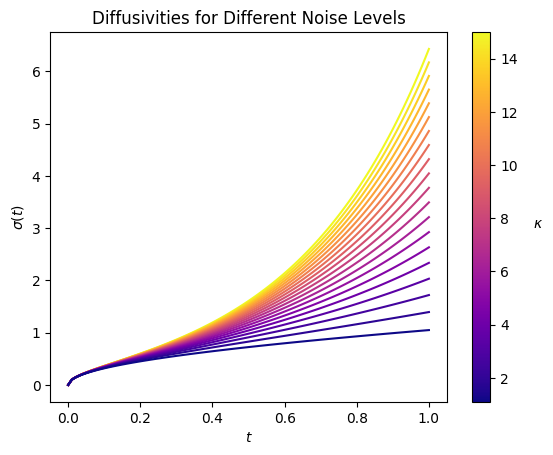

In [5]:
def _visualize_sigma_t():
    # Plot the width of the heat kernel over time
    fig, ax = plt.subplots(1, 1)
    ts = np.linspace(0, 1.0, 100)
    kappas = np.linspace(1.1, 15, 20)
    
    cmap = mpl.colormaps.get_cmap('plasma')
    norm = mpl.colors.Normalize(vmin=kappas[0], vmax=kappas[-1])  # Use same normalization
    
    for kappa in reversed(kappas):
        color = cmap(norm(kappa))  # normalize kappa consistently
        ax.plot(ts, variance_expanding_std(kappa, ts), color=color)
    
    # Colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # dummy array
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(r'$\kappa$', rotation=0, labelpad=15)
    
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$\sigma(t)$')
    ax.set_title('Diffusivities for Different Noise Levels')
    plt.show()

_visualize_sigma_t()

The differential operator $\Delta$ is the Laplace-Beltrami operator on whatever ambient space the samples $x$ occupy. In Euclidean space, $x \in \mathbb{R}^n$, $\Delta$ is just the familiar Laplacian given by $\Delta := \sum_{i=1}^n \partial_i^2$. In particuar, for a single, real-valued degree of freedom (with constant unit diffusivity), the heat equation is $$\partial_t u = \tfrac{1}{2}\partial_x^2 u,$$ and the fundamental solution (Green's function / propagator) for this PDE is called the *Heat Kernel* and is given by $$K(x, t) = \frac{1}{\sqrt{2\pi\sigma(t)^2}}e^{-\frac{x^2}{2\sigma(t)^2}},$$ where $\sigma(t)$ is the diffusivity from before.

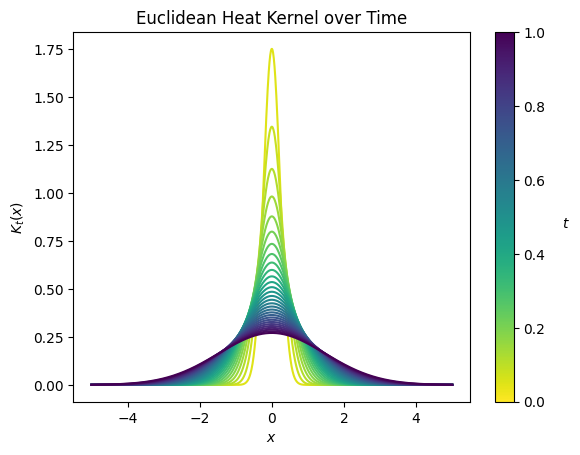

In [6]:
def euclidean_heat_kernel(x, *, width):
    """Computes the Euclidean heat kernel density K(x, t) for `x` at time `t`."""
    normalization = 1 / (2*np.pi * width**2)**0.5
    weight = torch.exp(-x**2 / (2 * width**2))
    return normalization * weight


def _visualize_heat_kernel():
    xs = torch.linspace(-5, 5, 1000)
    kappa = 2.0
    times = np.linspace(0.05, 1.0, 30)

    fig, ax = plt.subplots(1, 1)
    cmap = mpl.cm.viridis_r
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    
    for t in times:
        sigma_t = variance_expanding_std(kappa, t)
        color = cmap(norm(t))
        ax.plot(grab(xs), grab(euclidean_heat_kernel(xs, width=sigma_t)), color=color)
    
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # required for ScalarMappable
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('$t$', rotation=0, labelpad=15)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$K_t(x)$')
    ax.set_title('Euclidean Heat Kernel over Time')
    fig.show()

_visualize_heat_kernel()

One can easily sample from the Euclidean heat kernel at arbitrary time $t$; since $K(x, t)$ is always a normal distribution, you only need to know the marginal standard deviation at $t$.

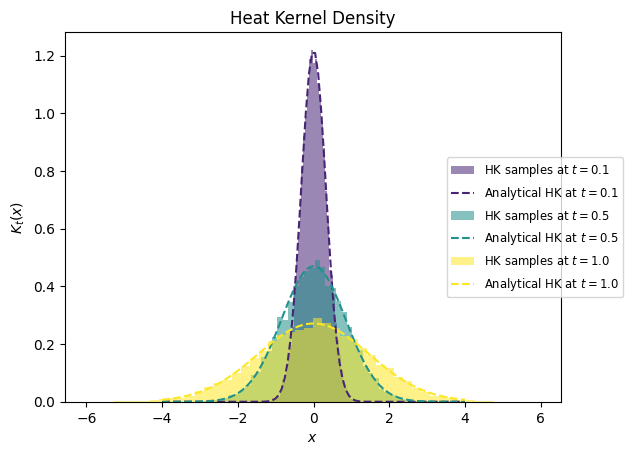

In [7]:
def sample_euclid_hk(batch_size, *, width):
    """Generates `batch_size` samples from the Euclidean Heat kernel."""
    x_t = width * torch.randn(batch_size)
    return x_t

def _test_sample_hk():
    batch_size = 16384
    xs = torch.linspace(-4, 4, 100)
    kappa = 2.0
    times = [0.1, 0.5, 1.0]
    
    cmap = plt.get_cmap('viridis')
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$K_t(x)$')
    for t in times:
        sigma_t = variance_expanding_std(kappa, t)
        xt = sample_euclid_hk(batch_size, width=sigma_t)
        ax.hist(grab(xt), bins=50, density=True, color=cmap(t), alpha=0.55, label=f'HK samples at $t = {t}$')
        ax.plot(grab(xs), grab(euclidean_heat_kernel(xs, width=sigma_t)), ls='--', color=cmap(t), label=f'Analytical HK at $t = {t}$')
    fig.legend(loc='right', fontsize='small')
    ax.set_title('Heat Kernel Density')
    fig.show()

_test_sample_hk()

It's also easy to simulate the forward process by directly feeding initial data (zero) into our diffuser object:

/u/octavio5/projects/sun_diffusion/venv/lib/python3.10/site-packages/torch/utils/_device.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


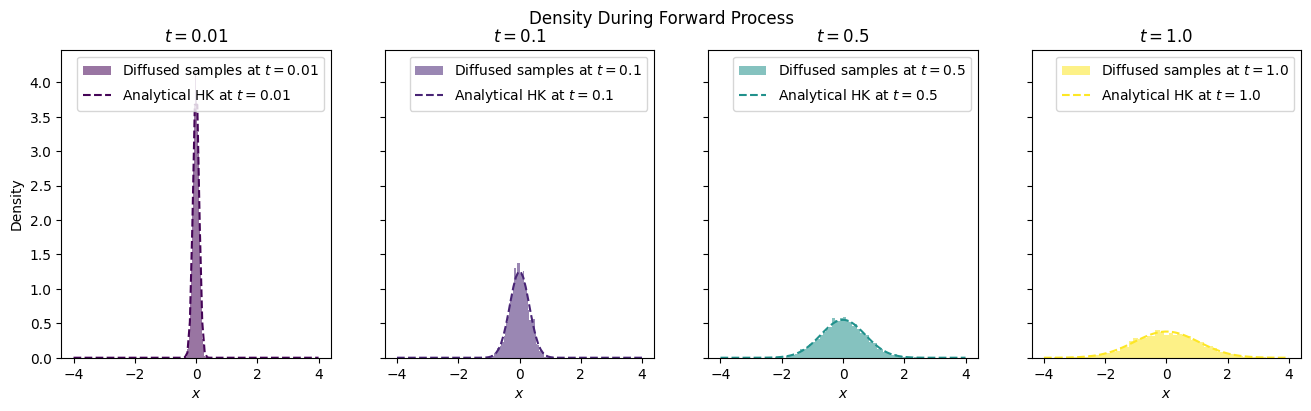

In [8]:
def visualize_euclid_fwd():
    """Simulates forward Euclidean VE diffusion process."""
    batch_size = 4096
    x_0 = torch.zeros((batch_size, 1))
    kappa = 1.1
    diffuser = VarianceExpandingDiffusion(kappa)
    
    xs = torch.linspace(-4, 4, 100)
    times = [0.01, 0.1, 0.5, 1.0]
    cmap = mpl.colormaps.get_cmap('viridis')
    
    fig, axes = plt.subplots(1, len(times), figsize=(4*len(times), 4), sharey=True)
    fig.suptitle('Density During Forward Process')
    axes[0].set_ylabel('Density')
    for t, ax in zip(times, axes):
        # Samples stats should match params of analytical HK
        x_t = diffuser(x_0, torch.tensor(t).repeat(batch_size))
        sigma_t = diffuser.sigma_func(t)
        assert torch.allclose(torch.std(x_t), torch.tensor(sigma_t), atol=5e-2), \
            f'StDev of samples {torch.std(x_t).item():.4f} does not match marginal HK StDev {sigma_t:.4f}'
        
        # Visualize forward process over time
        ax.set_title(f'$t = {t}$')
        ax.set_xlabel('$x$')
        ax.hist(grab(x_t), bins=50, density=True, color=cmap(t), alpha=0.55, label=f'Diffused samples at $t = {t}$')
        ax.plot(grab(xs), grab(euclidean_heat_kernel(xs, width=sigma_t)), ls='--', color=cmap(t), label=f'Analytical HK at $t = {t}$')
        ax.legend()
    fig.show()

visualize_euclid_fwd()

## Denoising with the Exact Score Function

The analytical score function for the Euclidean heat kernel is simply given by:

$$s(x, t) := \partial_x \log K(x, t) = -\frac{x}{\sigma(t)^2}$$

which can be used to solve either the ODE or SDE in reverse time: $$d\tilde{x} = -g(t)^2 s(x, t)dt + g(t) dW$$ $$d\tilde{x} = -\frac{1}{2}g(t)^2 s(x, t)dt$$

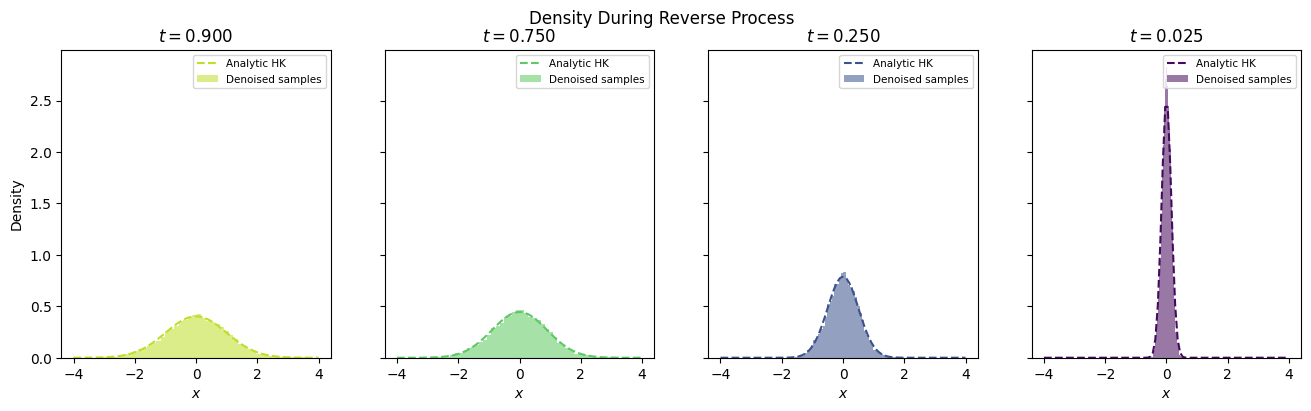

In [9]:
def denoise_backward(x_1, diffuser, num_steps=200, solver_type='ODE'):
    dt = 1 / num_steps
    t = 1.0
    x_t = x_1.clone()

    trajectories = []
    for step in range(num_steps):
        sigma_t = diffuser.sigma_func(t)
        g_t = diffuser.noise_coeff(t)
        score = eucl_score_hk(x_t, width=torch.tensor(sigma_t))
        
        # Integration step
        if solver_type == 'ODE':
            x_t = x_t + 0.5 * g_t**2 * score * dt
        elif solver_type == 'SDE':
            x_t = x_t + g_t**2 * score * dt + g_t * torch.randn_like(x_t) * dt**0.5
        else:
            raise NotImplementedError(f'Integration method {solver_type} not supported')
        t -= dt
        trajectories.append(x_t)
    return x_t, trajectories


def _test_denoise():
    batch_size = 8192
    diffuser = VarianceExpandingDiffusion(kappa=1.1)
    x_1 = sample_euclid_hk(batch_size, width=diffuser.sigma_func(1.0))
    
    num_steps = 200
    x_0, trajectories = denoise_backward(x_1, diffuser, num_steps, solver_type='ODE')
    
    cmap = mpl.colormaps.get_cmap('viridis')
    xs = torch.linspace(-4, 4, 100)
    steps = [20, 50, 150, 195]
    
    fig, axes = plt.subplots(1, len(steps), figsize=(4*len(steps), 4), sharey=True)
    fig.suptitle('Density During Reverse Process')
    axes[0].set_ylabel('Density')
    for ax, step in zip(axes, steps):
        # Check that stats of denoised samples match params of analytical HK
        t = 1 - step/num_steps
        x_t = trajectories[step]
        sigma_t = diffuser.sigma_func(t)
        #assert torch.allclose(torch.std(x_t), sigma_t, atol=5e-2), \
        #    f'StDev of samples {torch.std(x_t).item():.4f} does not match marginal HK StDev {sigma_t:.4f}'
        
        # Display reverse process plots
        ax.set_title(f'$t = {t:.3f}$')
        ax.set_xlabel('$x$')
        hk = euclidean_heat_kernel(xs, width=sigma_t)
        hk /= hk.sum() * (xs[1] - xs[0])
        ax.plot(grab(xs), grab(hk), ls='--', color=cmap(t), label=f'Analytic HK')
        ax.hist(grab(x_t), bins=50, color=cmap(t), alpha=0.55, density=True, label=f'Denoised samples')
        ax.legend(fontsize=7.5)
    fig.show()

_test_denoise()

## Denoising with a Trained Score Network

First we build a very simple MLP as our score network, which will input both $x$ and $t$ (for now, no special embeddings for $t$, just handle the raw time as-is)

In [10]:
class ScoreNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 8),  # data & time = 1 + 1 dims
            torch.nn.SiLU(),
            torch.nn.Linear(8, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 1))

    def forward(self, x_t, t):
        if len(t.shape) == 1:
            t = t.unsqueeze(-1)
        return self.net(torch.cat([x_t, t], dim=-1))


def _test_score_net():
    batch_size = 100
    x = torch.randn((batch_size, 1))
    t = torch.rand((batch_size,))
    s_t = ScoreNet()(x, t)
    print('x shape:', x.shape)
    print('t shape:', t.shape)
    print('s_t shape:', s_t.shape)
    assert s_t.shape == x.shape, \
        'Score output should have same shape as input'
    print('[PASSED]')

_test_score_net()

x shape: torch.Size([100, 1])
t shape: torch.Size([100])
s_t shape: torch.Size([100, 1])
[PASSED]


Define the conventional **score matching** loss

In [11]:
def score_matching_loss(x_0, diffuser, score_net, tol=1e-5):
    t = torch.rand((x_0.size(0),))
    t = tol + (1 - tol) * t  # stability near endpoints
    
    # Diffuse x_0 -> x_t, get s(x_t, t)
    x_t = diffuser(x_0, t.squeeze())
    sigma_t = diffuser.sigma_func(t)[:, None]
    score = score_net(x_t, t) / sigma_t  # rescale score net
    #NOTE: make sure shapes line up!! Can get silent side-effects
    
    # score should approximate grad log N(x_t; x_0, sigma_t^2)
    eps = (x_t - x_0) / sigma_t
    loss = (sigma_t * score + eps)**2  # weight factor of sigma(t)^2 for stability
    return torch.mean(loss)

Now do the training

In [12]:
# Diffusion params
kappa = 1.1
diffuser = VarianceExpandingDiffusion(kappa)
score_net = ScoreNet()

# Training hyperparams
lr = 1e-3
epochs = 1000
batch_size = 1024
optimizer = torch.optim.Adam(params=score_net.parameters(), lr=lr)

# Training loop
x_0 = torch.zeros((batch_size, 1))
losses = []
for epoch in tqdm.tqdm(range(epochs)):
    optimizer.zero_grad()
    loss = score_matching_loss(x_0, diffuser, score_net)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs} | Loss = {loss.item():.6f}')
    losses.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0/1000 | Loss = 0.983153
Epoch 100/1000 | Loss = 0.547133
Epoch 200/1000 | Loss = 0.128577
Epoch 300/1000 | Loss = 0.096196
Epoch 400/1000 | Loss = 0.072989
Epoch 500/1000 | Loss = 0.071576
Epoch 600/1000 | Loss = 0.061676
Epoch 700/1000 | Loss = 0.043713
Epoch 800/1000 | Loss = 0.033185
Epoch 900/1000 | Loss = 0.034508


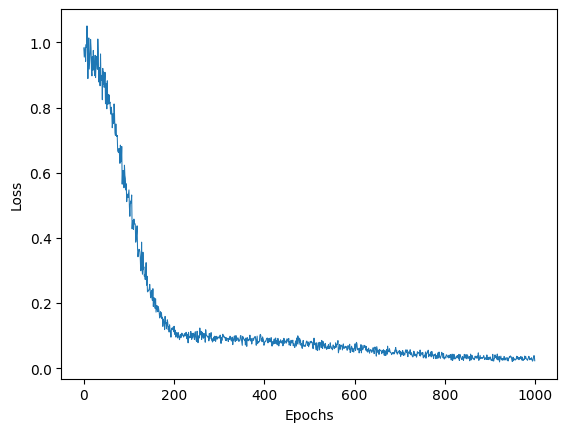

In [13]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.plot(losses, lw=0.75)
fig.show()

To generate new samples, we define a function to sample from the diffusion model posterior using our trained score network:

In [14]:
@torch.no_grad()
def euler_sampler(x_1, score_net, diffuser, num_steps=200, solver_type='ODE', verbose=False):
    score_net.eval()
    batch_size = x_1.size(0)
    
    trajectories = []
    dt = 1 / num_steps
    x_t = x_1.clone()
    t = 1.0
    for step in tqdm.tqdm(range(num_steps)):
        # Get ODE / SDE params
        sigma_t = diffuser.sigma_func(t)
        g_t = diffuser.noise_coeff(t)
        score = score_net(x_t, torch.tensor(t).repeat(batch_size,)) / sigma_t

        # Integration step
        if solver_type == 'ODE':
            x_t = x_t + 0.5 * g_t**2 * score * dt  # ODE Euler step
        elif solver_type == 'SDE':
            x_t = x_t + g_t**2 * score * dt + g_t * torch.randn_like(x_t) * dt**0.5  # SDE Euler-Maruyama step
        else:
            raise NotImplementedError(f'Integration method {solver_type} not supported')
        t -= dt

        # Collect and print metrics
        trajectories.append(x_t)
        if verbose:
            print(f'Step {step}/{num_steps} | x_t = {x_t.mean().item():.6f}')
    return x_t, trajectories

Since we are learning reverse evolution under the heat kernel only (i.e. no initial conditions), we should recover approximately a delta-function distributin $\delta(x)$, meaning that the samples should approach $0$ over reverse diffusion time.

  0%|          | 0/100 [00:00<?, ?it/s]

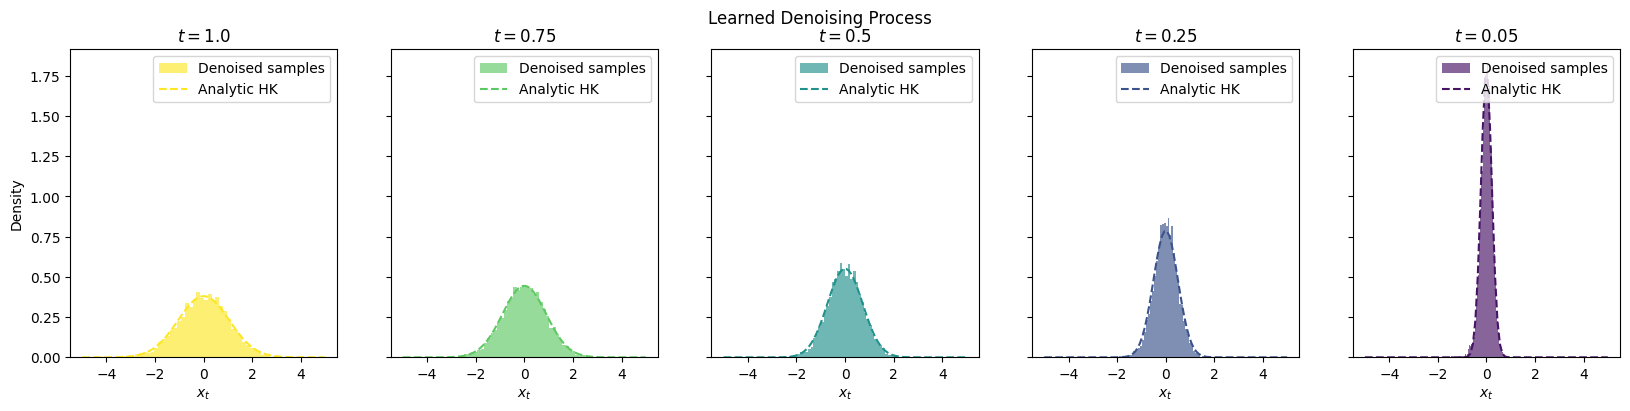

In [15]:
# Initial data: zeros
num_samples = 4096
x_0 = torch.zeros((num_samples, 1))

# Diffuse forward: x_0 -> x_1
sigma = 1.1
diffuser = VarianceExpandingDiffusion(sigma)
x_1 = diffuser(x_0, t=torch.ones((num_samples,)))

# Denoise backward: x_1 -> x_0'
num_steps = 100
x_0, trajectories = euler_sampler(x_1, score_net, diffuser, num_steps, solver_type='ODE')

# Plot trajectories
times = [1.0, 0.75, 0.5, 0.25, 0.05]
xs = torch.linspace(-5, 5, 100)
cmap = mpl.colormaps.get_cmap('viridis')

fig, axes = plt.subplots(1, len(times), figsize=(4*len(times), 4), sharey=True)
fig.suptitle('Learned Denoising Process')
axes[0].set_ylabel('Density')
for t, ax in zip(times, axes):
    # Denoised samples
    x_t = trajectories[int(num_steps * (1 - t))]
    ax.hist(grab(x_t), bins=50, density=True, color=cmap(t), alpha=0.65, label='Denoised samples')

    # Analytical heat kernel
    hk = euclidean_heat_kernel(xs, width=diffuser.sigma_func(t))
    hk /= hk.sum() * (xs[1] - xs[0])
    ax.plot(grab(xs), grab(hk), color=cmap(t), ls='--', label='Analytic HK')
    ax.set_xlabel(r'$x_t$')
    ax.set_title(f'$t = {t}$')
    ax.legend()
fig.show()